In [117]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import label_ranking_average_precision_score,average_precision_score,precision_recall_curve

In [102]:
with open(os.path.join('test_results','test_result_merged1and2.json'),'r') as f:
    results = json.load(f)

In [3]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

def mean_average_precision(y_true, y_pred):
    average_precisions = []
    # クラス単位でAPを計算
    for i in range(len(y_true)):
        sort_idx = np.argsort(y_pred[i])[::-1]
        y_true_sorted = y_true[i][sort_idx]

        cumsum = np.cumsum(y_true_sorted)
        recall = cumsum / np.max(cumsum)
        precision = cumsum / np.arange(1, 1 + y_true[i].shape[0])

        # 代表点
        points_x = np.arange(11) / 10
        points_y = np.zeros(points_x.shape[0])
        for i in range(points_x.shape[0]-1, -1, -1):
            points_y[i] = np.max(precision[recall >= points_x[i]])

        average_precision = np.mean(points_y)
        average_precisions.append(average_precision)
    return average_precisions

# IoUとｍAPの計算

In [115]:
result_files = ['test_result_merged1and2.json','test_result_part1.json','test_result_part2.json']

mAPs = {}
for rf in result_files:
    with open(os.path.join('test_results',rf),'r') as f:
        results = json.load(f)
    
    mAPs[rf] = []
    AP = {}
    
    for thresh_rate in range(1,8):
        total_AP = 0
        for i,target in enumerate(results.keys()):
            print(i,target)
            partial = results[target]
            partial_true = partial["ground truth"]
            partial_predict = partial["prediction"]
            true_bbox = []
            for t in partial_true:
                true_bbox.append(
                    [
                        t["bbox"]["left"],
                        t["bbox"]["top"],
                        t["bbox"]["right"],
                        t["bbox"]["bottom"]
                    ]
                )

            predict_bbox = []
            predict_score = []
            for t in partial_predict:
                predict_bbox.append(
                    [
                        t["bbox"]["left"],
                        t["bbox"]["top"],
                        t["bbox"]["right"],
                        t["bbox"]["bottom"],
                    ]
                )
                predict_score.append(t["score"])

            iou = []
            score = []
            for tb in true_bbox:
                for j,pb in enumerate(predict_bbox):
                    print("iou:",bb_intersection_over_union(tb,pb),"score:",predict_score[j])
                    iou.append(bb_intersection_over_union(tb,pb))
                    score.append(predict_score[j])
            iou = np.array(iou)
            iou = np.where(iou > (thresh_rate*0.1), True, False)
            score = np.array(score)
            precision, recall, threshold = precision_recall_curve(iou[::-1],score[::-1])
            print("precision:",precision)
            print("recall:",recall)
            print("threshold:",threshold)
            #print(iou,score)
            #print(average_precision_score(iou,score))
            #AP[target] = average_precision_score(iou,score)
            total_AP += average_precision_score(iou,score)

        mAPs[rf].append(total_AP/len(results.keys()))

0 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_2251.jpg
iou: 0.5129252510030207 score: 0.05973537266254425
iou: 0.5893124904925063 score: 0.17416632175445557
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.05973537 0.17416632]
1 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_143.jpg
iou: 0.0853440974537329 score: 0.18028363585472107
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.18028364]
2 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_1788.jpg
iou: 0.019714309581488596 score: 0.0889989361166954
iou: 0.03109949084904362 score: 0.10808044672012329
iou: 0.09908022948729624 score: 0.25977256894111633
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.25977257]
3 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_8823.jpg
iou: 0.42924507706414006 score: 0.12174438685178757
iou: 0.4851034702103975 score: 0.3660465180873871
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.12174439 0.36604652]
4 /home/tomita/keras-yolo3/use_images/n0223148

precision: [1. 1. 1. 1.]
recall: [1.         0.66666667 0.33333333 0.        ]
threshold: [0.06135865 0.08420076 0.17083763]
41 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_148.jpg
iou: 0.5276860211896548 score: 0.15899837017059326
iou: 0.22232819290081915 score: 0.44268396496772766
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.15899837 0.44268396]
42 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_9348.jpg
iou: 0.2131047152480098 score: 0.054612863808870316
iou: 0.07913139492086861 score: 0.05738721787929535
iou: 0.27802461270203205 score: 0.07942667603492737
iou: 0.07382475536633752 score: 0.12293197214603424
precision: [0.5        0.33333333 0.5        0.         1.        ]
recall: [1.  0.5 0.5 0.  0. ]
threshold: [0.05461286 0.05738722 0.07942668 0.12293197]
43 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_8677.jpg
iou: 0.35715321061023336 score: 0.055042266845703125
iou: 0.3689260338789111 score: 0.23939591646194458
precision: [1. 1. 1.]
r

precision: [0. 1.]
recall: [0. 0.]
threshold: [0.25977257]
3 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_8823.jpg
iou: 0.42924507706414006 score: 0.12174438685178757
iou: 0.4851034702103975 score: 0.3660465180873871
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.12174439 0.36604652]
4 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_6784.jpg
iou: 0.5820187171716275 score: 0.17627280950546265
iou: 0.3657251248025778 score: 0.3815910518169403
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.17627281 0.38159105]
5 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_9227.jpg
iou: 0.44419637380701193 score: 0.05236862972378731
iou: 0.19218943378712872 score: 0.052433986216783524
iou: 0.28964491541178655 score: 0.10276883095502853
iou: 0.31277401779253394 score: 0.13793541491031647
iou: 0.5922139205662603 score: 0.16792896389961243
precision: [0.6        0.5        0.66666667 1.         1.         1.        ]
recall: [1.         0.66666667 0.6666666

iou: 0.455319481331042 score: 0.17338863015174866
iou: 0.5042713940052344 score: 0.22351835668087006
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.17338863 0.22351836]
34 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_9254.jpg
iou: 0.15977882449313946 score: 0.06566502153873444
iou: 0.07359602356996833 score: 0.11209189146757126
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.11209189]
35 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_189.jpg
iou: 0.40489217003476596 score: 0.0854148119688034
iou: 0.5275263336304629 score: 0.21119605004787445
iou: 0 score: 0.0854148119688034
iou: 0.13634106276502272 score: 0.21119605004787445
precision: [0.5 0.5 1. ]
recall: [1.  0.5 0. ]
threshold: [0.08541481 0.21119605]
36 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_429.jpg
iou: 0.6940639269406392 score: 0.054808542132377625
iou: 0.22236975708818246 score: 0.08261769264936447
iou: 0.6390240497050508 score: 0.2377699315547943
precision: [0.66666667 0.5      

precision: [0. 1.]
recall: [0. 0.]
threshold: [0.52539378]
45 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_6571.jpg
iou: 0.29550851396459205 score: 0.051087405532598495
iou: 0.474863487742942 score: 0.08341211080551147
precision: [1. 1.]
recall: [1. 0.]
threshold: [0.08341211]
46 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10499.jpg
iou: 0.29716075406002784 score: 0.10382062941789627
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.10382063]
47 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10120.jpg
iou: 0.044612500397191064 score: 0.08104773610830307
iou: 0.1827714920625699 score: 0.14596179127693176
iou: 0.15087344190701482 score: 0.2722064256668091
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.27220643]
48 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_59.jpg
iou: 0.3827279545698061 score: 0.0528515949845314
iou: 0.37580971659919027 score: 0.2221788465976715
iou: 0.65872051827108 score: 0.3635122776031494
precision: [1. 1.]
recall: [1. 0.

30 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_4857.jpg
iou: 0.2794938622530531 score: 0.10244324058294296
iou: 0.6589404574060975 score: 0.10632947832345963
precision: [1. 1.]
recall: [1. 0.]
threshold: [0.10632948]
31 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10982.jpg
iou: 0 score: 0.06973417103290558
iou: 0.444157003697302 score: 0.08487052470445633
iou: 0.055302172623861126 score: 0.2975612282752991
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.29756123]
32 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10352.jpg
iou: 0.1244753122840141 score: 0.3984789550304413
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.39847896]
33 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_2116.jpg
iou: 0.455319481331042 score: 0.17338863015174866
iou: 0.5042713940052344 score: 0.22351835668087006
precision: [1. 1.]
recall: [1. 0.]
threshold: [0.22351836]
34 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_9254.jpg
iou: 0.15977882449313946 score: 0

precision: [0. 1.]
recall: [0. 0.]
threshold: [0.21119605]
36 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_429.jpg
iou: 0.6940639269406392 score: 0.054808542132377625
iou: 0.22236975708818246 score: 0.08261769264936447
iou: 0.6390240497050508 score: 0.2377699315547943
precision: [0.66666667 0.5        1.         1.        ]
recall: [1.  0.5 0.5 0. ]
threshold: [0.05480854 0.08261769 0.23776993]
37 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_1100.jpg
iou: 0.16749127649601583 score: 0.05124306306242943
iou: 0.2470648289943849 score: 0.11108658462762833
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.11108658]
38 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_3315.jpg
iou: 0.12914331758414827 score: 0.05395914614200592
iou: 0.4630860095976375 score: 0.10159124433994293
iou: 0.2723451174970712 score: 0.13703875243663788
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.13703875]
39 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_2230.jpg
iou: 0.28254

24 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_5399.jpg
iou: 0.19990352442133794 score: 0.06606237590312958
iou: 0.5578917985047039 score: 0.06876073032617569
iou: 0.1630995013858876 score: 0.10273672640323639
iou: 0.5209681247750817 score: 0.17593985795974731
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.17593986]
25 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10371.jpg
iou: 0.5597241938754817 score: 0.0865442082285881
iou: 0.24312431243124313 score: 0.3669515550136566
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.36695156]
26 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_7896.jpg
iou: 0.17466821545187639 score: 0.061259567737579346
iou: 0.76315207509153 score: 0.0788387879729271
precision: [1. 1.]
recall: [1. 0.]
threshold: [0.07883879]
27 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_8795.jpg
iou: 0.18857890148212728 score: 0.11519104987382889
iou: 0.28651873284022056 score: 0.36080363392829895
precision: [0. 1.]
recall: [0. 0.]
thre

precision: [1. 1. 1. 1. 1.]
recall: [1.   0.75 0.5  0.25 0.  ]
threshold: [0.05495865 0.24890666 0.27973241 0.30845013]
29 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_7272.jpg
iou: 0.5605128726459451 score: 0.06147401034832001
iou: 0.3467343461593071 score: 0.06241678446531296
iou: 0.27586329813304816 score: 0.14300568401813507
precision: [1. 1. 1. 1.]
recall: [1.         0.66666667 0.33333333 0.        ]
threshold: [0.06147401 0.06241678 0.14300568]
30 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_4857.jpg
iou: 0.14071570473954437 score: 0.05684983730316162
iou: 0.3120172444763787 score: 0.22257573902606964
iou: 0.29371154014988865 score: 0.24725404381752014
iou: 0.6613027174667839 score: 0.25171080231666565
precision: [1. 1. 1. 1. 1.]
recall: [1.   0.75 0.5  0.25 0.  ]
threshold: [0.05684984 0.22257574 0.24725404 0.2517108 ]
31 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10982.jpg
iou: 0 score: 0.05900994688272476
iou: 0.5560936936936937 score: 0.061

precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.15577583 0.74325728]
14 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_8472.jpg
iou: 0.37863800102921835 score: 0.06375403702259064
iou: 0.5185452099548381 score: 0.07138136029243469
iou: 0.21451772348538342 score: 0.0771503746509552
iou: 0.22425423474741418 score: 0.0783538669347763
iou: 0.18775179491796268 score: 0.1586540788412094
iou: 0.6807011461434923 score: 0.21062029898166656
iou: 0.61318858061922 score: 0.3839077055454254
precision: [0.85714286 0.83333333 0.8        0.75       0.66666667 1.
 1.         1.        ]
recall: [1.         0.83333333 0.66666667 0.5        0.33333333 0.33333333
 0.16666667 0.        ]
threshold: [0.06375404 0.07138136 0.07715037 0.07835387 0.15865408 0.2106203
 0.38390771]
15 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_9684.jpg
iou: 0.2455139298130739 score: 0.09760500490665436
iou: 0.4928306309826138 score: 0.3699379861354828
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
th

48 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_59.jpg
iou: 0.32945344129554655 score: 0.07483240216970444
iou: 0.4007557354925776 score: 0.09327440708875656
iou: 0.5280974949221394 score: 0.11763780564069748
iou: 0.6690548780487805 score: 0.14148923754692078
iou: 0.4563061667183142 score: 0.6003044247627258
iou: 0.617165991902834 score: 0.6115494966506958
iou: 0.7399826904633809 score: 0.734921932220459
precision: [1. 1. 1. 1. 1. 1. 1. 1.]
recall: [1.         0.85714286 0.71428571 0.57142857 0.42857143 0.28571429
 0.14285714 0.        ]
threshold: [0.0748324  0.09327441 0.11763781 0.14148924 0.60030442 0.6115495
 0.73492193]
49 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_5800.jpg
iou: 0.03869639658363271 score: 0.05958746373653412
iou: 0.4415797569027611 score: 0.1710856407880783
iou: 0.22986926063094015 score: 0.17612019181251526
iou: 0.07731196411827822 score: 0.6723701357841492
precision: [0.66666667 0.5        0.         1.        ]
recall: [1.  0.5 0.  0. ]

0 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_2251.jpg
iou: 0.6654664167043765 score: 0.07124502956867218
iou: 0.5019975981727275 score: 0.28216853737831116
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.07124503 0.28216854]
1 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_143.jpg
iou: 0 score: 0.053225111216306686
iou: 0.10295652173913043 score: 0.19599822163581848
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.19599822]
2 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_1788.jpg
iou: 0 score: 0.14917005598545074
iou: 0.04659904163295787 score: 0.32592394948005676
iou: 0.13342862469703562 score: 0.32779866456985474
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.32779866]
3 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_8823.jpg
iou: 0.7504558106941949 score: 0.05859237536787987
iou: 0.35250977835723596 score: 0.12749522924423218
iou: 0.4158210692136298 score: 0.7610382437705994
precision: [0.66666667 0.5        1.         1.        ]

32 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10352.jpg
iou: 0.1018025734551089 score: 0.5551846027374268
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.5551846]
33 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_2116.jpg
iou: 0.4574804340729771 score: 0.30053961277008057
iou: 0.5224360348004972 score: 0.394647479057312
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.30053961 0.39464748]
34 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_9254.jpg
iou: 0.09017656950672645 score: 0.10791382193565369
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.10791382]
35 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_189.jpg
iou: 0.5045907191349873 score: 0.05152406170964241
iou: 0.22596874200582281 score: 0.11335223913192749
iou: 0.3937632950026205 score: 0.3061662018299103
iou: 0.3637868426769845 score: 0.6418434381484985
iou: 0 score: 0.05152406170964241
iou: 0 score: 0.11335223913192749
iou: 0.2863468418274588 score: 0.3061662018299103
iou: 0.20

iou: 0.61318858061922 score: 0.3839077055454254
precision: [0.5        0.4        0.5        0.66666667 1.         1.
 1.        ]
recall: [1.         0.66666667 0.66666667 0.66666667 0.66666667 0.33333333
 0.        ]
threshold: [0.07138136 0.07715037 0.07835387 0.15865408 0.2106203  0.38390771]
15 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_9684.jpg
iou: 0.2455139298130739 score: 0.09760500490665436
iou: 0.4928306309826138 score: 0.3699379861354828
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.36993799]
16 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_473.jpg
iou: 0.4151499041676576 score: 0.1258712261915207
iou: 0.30098936786190805 score: 0.4782029390335083
iou: 0.5282730281931286 score: 0.6222140789031982
precision: [1. 1.]
recall: [1. 0.]
threshold: [0.62221408]
17 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_12685.jpg
iou: 0.14037139932738704 score: 0.07513013482093811
iou: 0.33648790746582546 score: 0.1047305017709732
iou: 0.3264706547040611 s

19 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_12911.jpg
iou: 0.32669983416252074 score: 0.15582726895809174
iou: 0.4291434156183991 score: 0.3470848798751831
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.34708488]
20 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_2106.jpg
iou: 0.4067186860354046 score: 0.07565051317214966
iou: 0.3036254150765723 score: 0.13543036580085754
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.13543037]
21 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_2322.jpg
iou: 0.49111044469197157 score: 0.06591985374689102
iou: 0.22939640162507255 score: 0.1805739849805832
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.18057398]
22 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10201.jpg
iou: 0.39817490494296576 score: 0.08132752776145935
iou: 0.25112019301787386 score: 0.33879518508911133
iou: 0.1298847343266798 score: 0.5411825776100159
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.54118258]
23 /home/tomita/keras-yolo3/u

iou: 0.3468295945042252 score: 0.09265246242284775
iou: 0.41789552611847036 score: 0.46937617659568787
iou: 0.42955315161279717 score: 0.5014699101448059
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.50146991]
5 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_9227.jpg
iou: 0.29467799897324737 score: 0.054560694843530655
iou: 0.2816323339717781 score: 0.05575227737426758
iou: 0.5044055676158856 score: 0.12837298214435577
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.12837298]
6 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_4525.jpg
iou: 0.03339517625231911 score: 0.0700521394610405
iou: 0.20545204942145517 score: 0.3353832960128784
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.3353833]
7 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_4030.jpg
iou: 0.26992198210324286 score: 0.057167306542396545
iou: 0.05765748127844941 score: 0.0717376247048378
iou: 0.4330055017284191 score: 0.10086751729249954
iou: 0.4437780505967356 score: 0.1757664829492569
precisi

iou: 0.4999271508705471 score: 0.05790632218122482
iou: 0.37559434709870565 score: 0.4589955806732178
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.05790632 0.45899558]
11 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_5700.jpg
iou: 0.18547345725083222 score: 0.051106106489896774
iou: 0.41735136729448447 score: 0.39852651953697205
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.05110611 0.39852652]
12 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_7500.jpg
iou: 0.3194496241191827 score: 0.07369129359722137
iou: 0.29458787944258397 score: 0.09729266166687012
iou: 0.419479461150739 score: 0.17171989381313324
precision: [1. 1. 1. 1.]
recall: [1.         0.66666667 0.33333333 0.        ]
threshold: [0.07369129 0.09729266 0.17171989]
13 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10506.jpg
iou: 0.8212056590034329 score: 0.07447364181280136
iou: 0.29248702209901944 score: 0.0880591943860054
iou: 0.41752108745745514 score: 0.1339819282293319

precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.05994137 0.2804057 ]
44 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_3491.jpg
iou: 0.3204043970151649 score: 0.07625357061624527
iou: 0.4060496465559757 score: 0.08234257996082306
iou: 0.21794287219705952 score: 0.3170052766799927
iou: 0.3233986383215229 score: 0.6052016615867615
precision: [1. 1. 1. 1. 1.]
recall: [1.   0.75 0.5  0.25 0.  ]
threshold: [0.07625357 0.08234258 0.31700528 0.60520166]
45 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_6571.jpg
iou: 0.4683479155944416 score: 0.05610562115907669
precision: [1. 1.]
recall: [1. 0.]
threshold: [0.05610562]
46 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10499.jpg
iou: 0.33010615711252655 score: 0.07595179229974747
iou: 0.2525261589819983 score: 0.12229741364717484
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.07595179 0.12229741]
47 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10120.jpg
iou: 0.08088960631333512 score: 

3 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_8823.jpg
iou: 0.4994528086550037 score: 0.09047473222017288
iou: 0.41257623137548993 score: 0.13638366758823395
iou: 0.373951928451649 score: 0.27196750044822693
iou: 0.4988548249123872 score: 0.297274649143219
precision: [1. 1. 1. 1. 1.]
recall: [1.   0.75 0.5  0.25 0.  ]
threshold: [0.09047473 0.13638367 0.2719675  0.29727465]
4 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_6784.jpg
iou: 0.4015452637220312 score: 0.0722055584192276
iou: 0.3948020897901355 score: 0.28294721245765686
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.07220556 0.28294721]
5 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_9227.jpg
iou: 0.4140143379173757 score: 0.063904769718647
iou: 0.20321654673430065 score: 0.08062943071126938
iou: 0.6358215714393539 score: 0.13814331591129303
iou: 0.34468777933852635 score: 0.1555362343788147
precision: [0.75       0.66666667 1.         1.         1.        ]
recall: [1.         0.6666

iou: 0 score: 0.069783054292202
iou: 0.10355565672661052 score: 0.09940476715564728
iou: 0.016677127230341614 score: 0.357878178358078
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.35787818]
32 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10352.jpg
iou: 0.10381142876087125 score: 0.05419021099805832
iou: 0.126932019052429 score: 0.26785603165626526
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.26785603]
33 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_2116.jpg
iou: 0.21902594197334505 score: 0.07323666661977768
iou: 0.38470606792690926 score: 0.11999025195837021
iou: 0.4816417702080134 score: 0.2554570436477661
precision: [1. 1. 1.]
recall: [1.  0.5 0. ]
threshold: [0.11999025 0.25545704]
34 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_9254.jpg
iou: 0.053836188282711965 score: 0.10908198356628418
iou: 0.07120743034055728 score: 0.14587348699569702
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.14587349]
35 /home/tomita/keras-yolo3/use_images/n022

10 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10829.jpg
iou: 0.4999271508705471 score: 0.05790632218122482
iou: 0.37559434709870565 score: 0.4589955806732178
precision: [0.5 0.  1. ]
recall: [1. 0. 0.]
threshold: [0.05790632 0.45899558]
11 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_5700.jpg
iou: 0.18547345725083222 score: 0.051106106489896774
iou: 0.41735136729448447 score: 0.39852651953697205
precision: [1. 1.]
recall: [1. 0.]
threshold: [0.39852652]
12 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_7500.jpg
iou: 0.3194496241191827 score: 0.07369129359722137
iou: 0.29458787944258397 score: 0.09729266166687012
iou: 0.419479461150739 score: 0.17171989381313324
precision: [1. 1.]
recall: [1. 0.]
threshold: [0.17171989]
13 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10506.jpg
iou: 0.8212056590034329 score: 0.07447364181280136
iou: 0.29248702209901944 score: 0.0880591943860054
iou: 0.41752108745745514 score: 0.13398192822933197
iou: 0.19023560

threshold: [0.1795658]
17 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_12685.jpg
iou: 0.2576140246620116 score: 0.38765567541122437
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.38765568]
18 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_6008.jpg
iou: 0.24818592305140005 score: 0.09644211083650589
iou: 0.22226640159045727 score: 0.19626685976982117
iou: 0.11893357433348396 score: 0.2152060866355896
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.21520609]
19 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_12911.jpg
iou: 0.3807612250966399 score: 0.0754615068435669
iou: 0.15817275185936444 score: 0.07600805908441544
iou: 0.24292293701780632 score: 0.42194506525993347
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.42194507]
20 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_2106.jpg
iou: 0.07850664258025668 score: 0.05892002210021019
iou: 0.34968278326195 score: 0.06743697822093964
iou: 0.3163386878106898 score: 0.1828642189502716
precision: [0. 

threshold: [0.81998891]
50 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_11404.jpg
iou: 0.4949269525505642 score: 0.3330477774143219
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.33304778]
0 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_2251.jpg
iou: 0.5266056922447548 score: 0.05584552884101868
iou: 0.37078389043958915 score: 0.12545837461948395
iou: 0.6251814574663699 score: 0.2684972882270813
precision: [1. 1.]
recall: [1. 0.]
threshold: [0.26849729]
1 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_143.jpg
iou: 0.06180427775385298 score: 0.05028682202100754
iou: 0 score: 0.07850462943315506
iou: 0.09622104835432752 score: 0.19078092277050018
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.19078092]
2 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_1788.jpg
iou: 0.04901328517993035 score: 0.08208180218935013
iou: 0.057536112056806574 score: 0.1395169496536255
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.13951695]
3 /home/tomita/keras-yolo3

iou: 0.07719207356560032 score: 0.05840303376317024
iou: 0.26914450496635695 score: 0.26379284262657166
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.26379284]
30 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_4857.jpg
iou: 0.1214846656195751 score: 0.06277379393577576
iou: 0.20409266219569117 score: 0.1403166651725769
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.14031667]
31 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10982.jpg
iou: 0 score: 0.069783054292202
iou: 0.10355565672661052 score: 0.09940476715564728
iou: 0.016677127230341614 score: 0.357878178358078
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.35787818]
32 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10352.jpg
iou: 0.10381142876087125 score: 0.05419021099805832
iou: 0.126932019052429 score: 0.26785603165626526
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.26785603]
33 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_2116.jpg
iou: 0.21902594197334505 score: 0.0732366666197

14 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_8472.jpg
iou: 0.5122446269704269 score: 0.08125272393226624
iou: 0.33379539783753814 score: 0.11163480579853058
iou: 0.26649653663871675 score: 0.24427726864814758
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.24427727]
15 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_9684.jpg
iou: 0.533267262292172 score: 0.5483995676040649
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.54839957]
16 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_473.jpg
iou: 0.4106016456219089 score: 0.0623510368168354
iou: 0.42274869543936655 score: 0.0910000279545784
iou: 0.7685173960480058 score: 0.17956580221652985
precision: [1. 1.]
recall: [1. 0.]
threshold: [0.1795658]
17 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_12685.jpg
iou: 0.2576140246620116 score: 0.38765567541122437
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.38765568]
18 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_6008.jpg
iou: 0.24818592305

47 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_10120.jpg
iou: 0.08088960631333512 score: 0.06305362284183502
iou: 0.2039392798895998 score: 0.1278693675994873
iou: 0.1744899937528274 score: 0.22462593019008636
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.22462593]
48 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_59.jpg
iou: 0.3309919028340081 score: 0.061442743986845016
iou: 0.6767773602270113 score: 0.12294858694076538
iou: 0.6121287426349753 score: 0.27684906125068665
iou: 0.47365721997300947 score: 0.40915337204933167
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.40915337]
49 /home/tomita/keras-yolo3/use_images/n02231487/n02231487_5800.jpg
iou: 0.2933043369160637 score: 0.05453161522746086
iou: 0.35753176043557167 score: 0.09442882239818573
iou: 0.21521356748469142 score: 0.15853118896484375
iou: 0.2785162072614092 score: 0.8199889063835144
precision: [0. 1.]
recall: [0. 0.]
threshold: [0.81998891]
50 /home/tomita/keras-yolo3/use_images/n02231487/n022314

In [116]:
mAPs

{'test_result_merged1and2.json': [0.9297385620915032,
  0.7980392156862745,
  0.6428104575163398,
  0.5022875816993464,
  0.3169934640522876,
  0.11437908496732026,
  0.0392156862745098],
 'test_result_part1.json': [0.9414488017429194,
  0.8387215997510116,
  0.6456115779645191,
  0.5031045751633987,
  0.3090686274509804,
  0.16666666666666666,
  0.03594771241830065],
 'test_result_part2.json': [0.9281045751633987,
  0.8239651416122004,
  0.5887799564270153,
  0.4455337690631808,
  0.22712418300653595,
  0.11601307189542484,
  0.024509803921568627]}

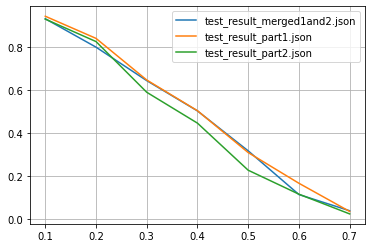

In [121]:
thresh_rate_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7]
fig = plt.figure()
ax = fig.add_subplot(111)

for file in mAPs.keys():
    ax.plot(thresh_rate_values,mAPs[file],label=file)
ax.grid(axis='both')
ax.legend()

In [104]:
AP

{'/home/tomita/keras-yolo3/use_images/n02231487/n02231487_1002.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10120.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10201.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10352.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10371.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10499.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10506.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10829.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10982.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_1100.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_11404.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_12685.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_12911.jpg': -0.0,
 '/home/tomita

In [107]:
import matplotlib.pyplot

Matplotlib created a temporary config/cache directory at /home/tomita/.cache/matplotlib because the default path (/tmp/matplotlib-dh9vbo6e) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [105]:
#merged 1 and 2
ap = 0
for a in AP.keys():
    ap += abs(AP[a])
ap/len(AP.keys())

0.0392156862745098

In [101]:
#part 1
ap = 0
for a in AP.keys():
    ap += AP[a]
ap/len(AP.keys())

0.03594771241830065

In [97]:
#part 2
ap = 0
for a in AP.keys():
    ap += AP[a]
ap/len(AP.keys())

0.024509803921568627

In [21]:
AP

{'/home/tomita/keras-yolo3/use_images/n02231487/n02231487_1002.jpg': 0.8333333333333333,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10120.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10201.jpg': 0.8333333333333333,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10352.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10371.jpg': 0.9166666666666665,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10499.jpg': 1.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10506.jpg': 0.6388888888888888,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10829.jpg': 1.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_10982.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_1100.jpg': -0.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_11404.jpg': 1.0,
 '/home/tomita/keras-yolo3/use_images/n02231487/n02231487_12685.jpg': 1.0,
 '/home/tomita/keras-yolo3/use_images/

In [15]:
precision_recall_curve(np.array([0, 0, 1, 1]),np.array([0.1, 0.4, 0.35, 0.8]))

(array([0.66666667, 0.5       , 1.        , 1.        ]),
 array([1. , 0.5, 0.5, 0. ]),
 array([0.35, 0.4 , 0.8 ]))

In [8]:
precision

array([1., 1.])

In [9]:
recall

array([1., 0.])

In [10]:
threshold

array([0.33304778])

In [112]:
arr

array([[0.50459072, 0.22596874, 0.3937633 , 0.36378684, 0.        ,
        0.        , 0.28634684, 0.2008555 ],
       [0.05152406, 0.11335224, 0.3061662 , 0.64184344, 0.05152406,
        0.11335224, 0.3061662 , 0.64184344]])

In [16]:
arr[0] = np.where(arr[0] > 0.2, True, False)

In [17]:
arr

array([[1.        , 1.        , 1.        , 1.        , 0.        ,
        0.        , 1.        , 1.        ],
       [0.05152406, 0.11335224, 0.3061662 , 0.64184344, 0.05152406,
        0.11335224, 0.3061662 , 0.64184344]])

In [120]:
arr[0][::-1]

array([1., 1., 0., 0., 1., 1., 1., 1.])

In [115]:
AP = 0
for a in arr.T:
    print(a[0] * a[1])
    AP += a[0] * a[1]

0.05152406170964241
0.11335223913192749
0.3061662018299103
0.6418434381484985
0.0
0.0
0.3061662018299103
0.6418434381484985


In [116]:
AP

2.0608955807983875

In [117]:
AP/len(arr.T)

0.25761194759979844

In [20]:
mean_average_precision([arr[0]],[arr[1]])

[0.9242424242424243]

In [37]:
label_ranking_average_precision_score([arr[0][::-1]],[arr[1][::-1]])

0.9305555555555555

In [38]:
arr

array([[1.        , 1.        , 1.        , 1.        , 0.        ,
        0.        , 1.        , 1.        ],
       [0.05152406, 0.11335224, 0.3061662 , 0.64184344, 0.05152406,
        0.11335224, 0.3061662 , 0.64184344]])

In [28]:
average_precision_score(arr[0][::-1],arr[1][::-1])

0.9305555555555556

In [25]:
average_precision_score(np.array([0, 0, 1, 1]),np.array([0.1, 0.4, 0.35, 0.8]))

0.8333333333333333

In [26]:
np.array([0.1, 0.4, 0.35, 0.8])[::-1]

array([0.8 , 0.35, 0.4 , 0.1 ])